In [1]:
import cv2
import os
from operator import itemgetter
from numpy import array
import csv
import time
import matplotlib.pyplot as plt
import keras
import tensorflow as tf
from sklearn.metrics import confusion_matrix

## Usage

1. Define the paths
2. Specify the classifier to be trained and the classes array
3. Define the training variables
4. Run the remaining code

In [2]:
# Define the paths

pathTrainArray = ['/home/ruben/Desktop/isic_2018/train_2018/',
                  '/home/ruben/Desktop/isic_2018/hier/b/',
                  '/home/ruben/Desktop/isic_2018/hier/c/',
                  '/home/ruben/Desktop/isic_2018/hier/d/',
                  '/home/ruben/Desktop/isic_2018/hier/e/']

truthTrainArray = ['/home/ruben/Desktop/isic_2018/hier/a/labels.csv',
                   '/home/ruben/Desktop/isic_2018/hier/b/labels.csv',
                   '/home/ruben/Desktop/isic_2018/hier/c/labels.csv',
                   '/home/ruben/Desktop/isic_2018/hier/d/labels.csv',
                   '/home/ruben/Desktop/isic_2018/hier/e/labels.csv']

pathValArray  = ['/home/ruben/Desktop/isic_2018/val_2018/',
                 '/home/ruben/Desktop/isic_2018/hier_val/b/',
                 '/home/ruben/Desktop/isic_2018/hier_val/c/',
                 '/home/ruben/Desktop/isic_2018/hier_val/d/',
                 '/home/ruben/Desktop/isic_2018/hier_val/e/']

truthValArray = ['/home/ruben/Desktop/isic_2018/hier_val/a/labels.csv',
                 '/home/ruben/Desktop/isic_2018/hier_val/b/labels.csv',
                 '/home/ruben/Desktop/isic_2018/hier_val/c/labels.csv',
                 '/home/ruben/Desktop/isic_2018/hier_val/d/labels.csv',
                 '/home/ruben/Desktop/isic_2018/hier_val/e/labels.csv']

checkpointPath = {
    'resnet': ["/home/ruben/Desktop/isic_2018/model_weights/hier/resnet/a/cp.ckpt",
               "/home/ruben/Desktop/isic_2018/model_weights/hier/resnet/b/cp.ckpt",
               "/home/ruben/Desktop/isic_2018/model_weights/hier/resnet/c/cp.ckpt",
               "/home/ruben/Desktop/isic_2018/model_weights/hier/resnet/d/cp.ckpt",
               "/home/ruben/Desktop/isic_2018/model_weights/hier/resnet/e/cp.ckpt"],
    'densenet': ["/home/ruben/Desktop/isic_2018/model_weights/hier/densenet/a/cp.ckpt",
                "/home/ruben/Desktop/isic_2018/model_weights/hier/densenet/b/cp.ckpt",
                "/home/ruben/Desktop/isic_2018/model_weights/hier/densenet/c/cp.ckpt",
                "/home/ruben/Desktop/isic_2018/model_weights/hier/densenet/d/cp.ckpt",
                "/home/ruben/Desktop/isic_2018/model_weights/hier/densenet/e/cp.ckpt"]
}

In [3]:
# Specify the classifier to be trained and the classes array
# a: ['MEL', 'NMEL']
# b: ['MEL', 'NV']
# c: ['BEN', 'MAL']
# d: ['BKL', 'DF', 'VASC']
# e: ['BCC', 'AKIEC']

classifier = 'e'
classesArray = ['BCC', 'AKIEC']

# Define training variables
noEpochs = 5
learningRate = 1e-5
noClasses = len(classesArray)
batchSize = 10
modelName = 'densenet'

In [4]:
# imports all the images from a specified folder, with a specific extension
# and resizes to a specific imgHeight, imgWidth

def import_dataset(path, mode, fileExtension='.jpg', imgWidth=224, imgHeight=224):
    datasetFilenamesImages = []
    dataset = []
    print("Start importing " + mode + " images...")
    for filename in os.listdir(path):
        if filename.endswith(fileExtension): 
            completePath = os.path.join(path, filename)
            image = cv2.imread(completePath, cv2.IMREAD_COLOR)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            image = cv2.resize(image, dsize=(imgHeight, imgWidth), interpolation=cv2.INTER_AREA)
            filenameImage = [filename, image]
            datasetFilenamesImages.append(filenameImage)
        else:
            continue
    
    datasetFilenamesImages = sorted(datasetFilenamesImages, key=itemgetter(0))
    for x in datasetFilenamesImages:
        dataset.append(x[1])
    
    return array(dataset)

In [5]:
def assign_labels(path_groundtruth, classesArray):
    target = []
    if len(classesArray) == 2:
        counter = {classesArray[0]: 0, classesArray[1]: 0}
    elif len(classesArray) == 3:
        counter = {classesArray[0]: 0, classesArray[1]: 0, classesArray[2]: 0}
        
    i = 0
    with open(path_groundtruth, 'r') as file:
        reader = csv.reader(file)
        for row in reader:
            if i == 0:
                i += 1
                continue

            if row[1] == '1.0': # BCC
                counter[classesArray[0]] += 1
                target.append(0)
            elif row[2] == '1.0': # AKIEC
                counter[classesArray[1]] += 1
                target.append(1)
                
            if len(classesArray) == 3:
                if row[3] == '1.0':
                    counter[classesArray[2]] += 1
                    target.append(2)

    print(counter)
    file.close()
    return counter, target

In [6]:
def plot_val_train_error(fit):
    plt.plot(fit.history['accuracy'])
    plt.plot(fit.history['val_accuracy'])
    plt.grid(True)
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()

    plt.plot(fit.history['loss'])
    plt.plot(fit.history['val_loss'])
    plt.grid(True)
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()

In [7]:
def create_model(model = 'densenet', transferLearning=True, noClasses=2, imgWidth=224, imgHeight=224):
    if model == 'resnet':

        from tensorflow.keras.applications.resnet import ResNet101
        from tensorflow.keras.layers import Dense, GlobalAveragePooling2D

        if transferLearning == False:
            resnet = ResNet101(include_top=False, weights=None, input_shape=(imgHeight, imgWidth, 3))
        else:
            resnet = ResNet101(include_top=False, weights='imagenet', input_shape=(imgHeight, imgWidth, 3))

        model = tf.keras.Sequential(resnet)
        model.add(GlobalAveragePooling2D())
        model.add(tf.keras.layers.Dropout(0.5))
        model.add(Dense(units=noClasses, activation="softmax"))

    elif model == 'densenet':

        from tensorflow.keras.applications.densenet import DenseNet121
        from tensorflow.keras.layers import Dense, GlobalAveragePooling2D

        if transferLearning == False:
            densenet = DenseNet121(include_top=False, weights=None, input_shape=(imgHeight, imgWidth, 3))
        else:
            densenet = DenseNet121(include_top=False, weights='imagenet', input_shape=(imgHeight, imgWidth, 3))

        model = tf.keras.Sequential(densenet)
        model.add(GlobalAveragePooling2D())
        model.add(tf.keras.layers.Dropout(0.5))
        model.add(Dense(units=noClasses, activation="softmax"))

    else:
        print("That model is not available.")
        exit(0)

    return model

In [8]:
# Learning Rate Scheduler
def scheduler(epoch):
    global learningRate
    global noEpochs
    if epoch < int(0.5 * noEpochs):
        return learningRate
    elif epoch < int(0.75 * noEpochs):
        return learningRate / 10
    else:
        return learningRate / 100

In [9]:
# Import Training and Validation datasets and Groundtruth of classifier
classifierToIndex = {'a': 0, 'b': 1, 'c': 2, 'd': 3, 'e': 4}
indexClassifier = classifierToIndex[classifier]

x_train = import_dataset(pathTrainArray[indexClassifier], 'training')
counter, y_train = assign_labels(truthTrainArray[indexClassifier], classesArray)

x_val = import_dataset(pathValArray[indexClassifier], 'validation')
counter, y_val = assign_labels(truthValArray[indexClassifier], classesArray)

print("Dataset Imported")

Start importing training images...
{'BCC': 3, 'AKIEC': 3}
Start importing validation images...
{'BCC': 1, 'AKIEC': 1}
Dataset Imported


In [10]:
w_0_float = float(counter[classesArray[0]])
w_1_float = float(counter[classesArray[1]])


if noClasses == 2:
    w_total = w_0_float + w_1_float
    w_0 = w_total / w_0_float
    w_1 = w_total / w_1_float
    classWeights = {0: w_0, 1: w_1}
elif noClasses == 3:
    w_2_float = float(counter[classesArray[2]])
    w_total = w_0_float + w_1_float + w_2_float
    w_0 = w_total / w_0_float
    w_1 = w_total / w_1_float
    w_2 = w_total / w_2_float
    classWeights = {0: w_0, 1: w_1, 2: w_2}

y_train_cat = keras.utils.to_categorical(y_train, noClasses)
y_val_cat = keras.utils.to_categorical(y_val, noClasses)

# Callback to adapt the learning rate value
schedulerLearningRate = tf.keras.callbacks.LearningRateScheduler(scheduler)

# Callback to save the Best Model Weights
checkpoint_dir = os.path.dirname(checkpointPath[modelName][indexClassifier])
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpointPath[modelName][indexClassifier],
    save_weights_only=True,
    verbose=1, 
    save_best_only=True
)

In [11]:
# Create and fit the model
model = create_model(modelName, True, noClasses, 224, 224)
model.summary()

model.compile(
    loss = keras.losses.categorical_crossentropy,
    optimizer = tf.keras.optimizers.Adam(lr=1e-5),
    metrics = ['accuracy']
)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet121 (Model)          (None, 7, 7, 1024)        7037504   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1024)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense (Dense)                (None, 2)                 2050      
Total params: 7,039,554
Trainable params: 6,955,906
Non-trainable params: 83,648
_________________________________________________________________


In [12]:
fit = model.fit(
    x_train,
    y_train_cat,
    batch_size=batchSize,
    class_weight=classWeights,
    callbacks=[schedulerLearningRate, checkpoint],
    epochs=noEpochs,
    shuffle=True,
    validation_data=(x_val, y_val_cat)
)

Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 1.9867 - accuracy: 0.5000
Epoch 00001: val_loss improved from inf to 0.80317, saving model to /home/ruben/Desktop/isic_2018/model_weights/hier/densenet/e/cp.ckpt
1/1 [==============================] - 7s 7s/step - loss: 1.9867 - accuracy: 0.5000 - val_loss: 0.8032 - val_accuracy: 0.5000 - lr: 1.0000e-05
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 1.0405 - accuracy: 0.8333
Epoch 00002: val_loss improved from 0.80317 to 0.60449, saving model to /home/ruben/Desktop/isic_2018/model_weights/hier/densenet/e/cp.ckpt
1/1 [==============================] - 2s 2s/step - loss: 1.0405 - accuracy: 0.8333 - val_loss: 0.6045 - val_accuracy: 0.5000 - lr: 1.0000e-05
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 0.9627 - accuracy: 0.6667
Epoch 00003: val_loss did not improve from 0.60449
1/1 [==============================] - 1s 510ms/step - loss: 0.9627 - accuracy: 0.6667 - val_loss: 0.6415 - val_ac

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
[[1 0]
 [1 0]]
1/1 [==============================] - 0s 2ms/step - loss: 0.6045 - accuracy: 0.5000
Val loss: 0.6044867038726807 / Val accuracy: 0.5


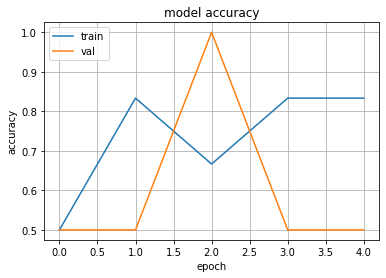

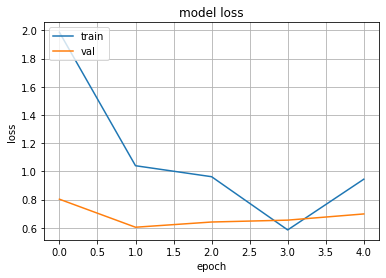

In [13]:
# Evaluate in validation set
model.load_weights(checkpointPath[modelName][indexClassifier])

y_pred = model.predict_classes(x_val)
conf_matrix = confusion_matrix(y_val, y_pred)
print(conf_matrix)

score = model.evaluate(x_val, y_val_cat, verbose=1)
print(f'Val loss: {score[0]} / Val accuracy: {score[1]}')

plot_val_train_error(fit)